# Implement Random-Forests using python

### Define Data and Project Goal

We will be exploring publicly available data from [LendingClub.com](www.lendingclub.com). 
    - Lending Club connects people who need money (borrowers) with people who have money (investors). 

Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. 
     - We will try to create a model that will help predict this.


#### Goal
To classify and predict whether or not the borrower paid back their loan in full. 

#### Data Description

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

# Import Libraries

**Import the usual libraries for pandas and plotting. You can import sklearn later on.**

In [171]:
import pandas as pd
import numpy as np
from numpy import sqrt,argmax,arange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, precision_recall_curve

## Read Data

In [2]:
loans = pd.read_csv('loan_data.csv')

Lets check out the info(), head(), and describe() methods on loans.

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [5]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Exploratory Data Analysis

Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities.

## FICO Distributions for credit policy outcome
It seems most of the applicant passed the credit policy criteria.

Text(0.5, 0, 'FICO')

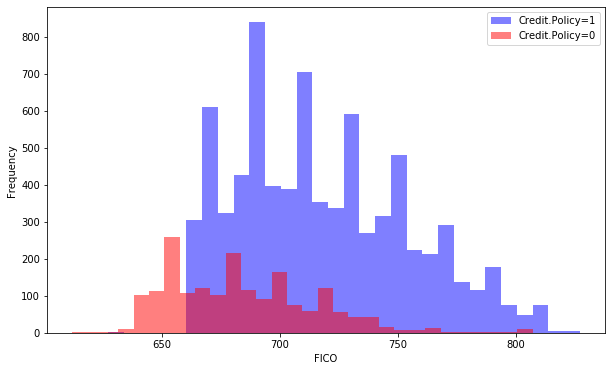

In [10]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].plot.hist(alpha=0.5,bins=30,color='blue',label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].plot.hist(alpha=0.5,bins=30,color='red',label='Credit.Policy=0')                                        
plt.legend()
plt.xlabel('FICO')

## FICO Distributions for not fully paid customers 
Majority of the customers have fully paid their credit balances. We do not have many customer data that has not fully paid (which we wish to predict) and hence will be dealing with class imblance data.

Text(0.5, 0, 'FICO')

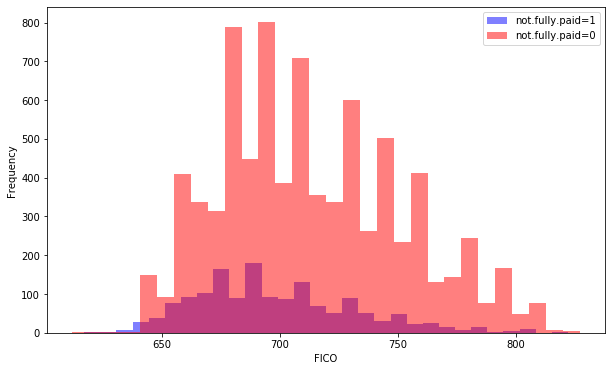

In [11]:
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].plot.hist(alpha=0.5,bins=30,color='blue',label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].plot.hist(alpha=0.5,bins=30,color='red',label='not.fully.paid=0')                                        
plt.legend()
plt.xlabel('FICO')

## Loan Purpose
Lets look at the counts of loans by purpose, with the color hue defined by `not.fully.paid`. It seems like `debt_consolidation` is the major loan purpose for all the customers.

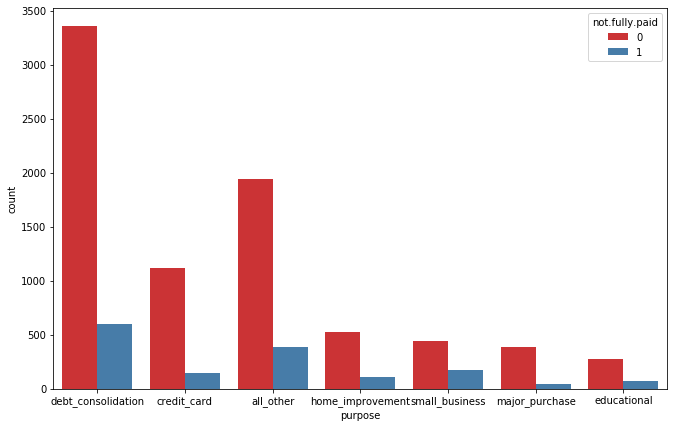

In [12]:
plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=loans,palette='Set1')

## Trend between FICO score and Interest Rate

This makes sense, higher th FICO rate, lower is the interest rate.

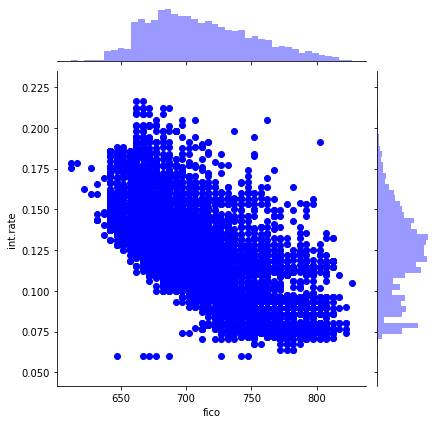

In [134]:
sns.jointplot(x='fico',y='int.rate',data=loans,color='blue')

# Predictions: Model Building

Let's get ready to set up our data for **Random Forest Classification Model**.

## Data Formatting for Categorical Features

Notice that the **purpose** column as categorical. Lets expanded it multiple categorical features by creating a list of 1 element containing the string 'purpose'. Lets call this list as cat_feats. Then we use **pd.get_dummies(loans,columns=cat_feats,drop_first=True)** to create a fixed larger dataframe that has new feature columns with **dummy** variables. Lets call this dataframe as `final_data`. 

In [137]:
cat_feats = ['purpose']
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit.policy               9578 non-null   int64  
 1   int.rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log.annual.inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   int64  
 6   days.with.cr.line           9578 non-null   float64
 7   revol.bal                   9578 non-null   int64  
 8   revol.util                  9578 non-null   float64
 9   inq.last.6mths              9578 non-null   int64  
 10  delinq.2yrs                 9578 non-null   int64  
 11  pub.rec                     9578 non-null   int64  
 12  not.fully.paid              9578 non-null   int64  
 13  purpose_credit_card         9578 

## Train Test Split

Lets split the data into a training set and a testing set!

In [17]:
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

## Check Class Balance

In [176]:
#check if data is balanced or not
weights=compute_class_weight('balanced', np.unique(y_train), y_train)
print('class balance for classes [1 0] = ', weights)

class balance for classes [1 0] =  [0.59687024 3.08077198]


## Training the Random Forest model

Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step. Since, the class `not.fully.paid=0` is a minority class, meaning we are dealing with class imbalance data, we will use parameter `class_weight="balanced"` wherein classes are automatically weighted inversely proportional to how frequently they appear in the data.

In [123]:
rfc = RandomForestClassifier(n_estimators=600, class_weight="balanced") #
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=600)

## Predictions and Evaluation

Let's predict the class of `not.fully.paid` for the X_test data. The recall and precision for class `not.fully.paid=1` are very low, epecially recall as we should not risk to give loan to customers who will not pay back.

In [119]:
predictions = rfc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       824
           1       0.50      0.01      0.03       134

    accuracy                           0.86       958
   macro avg       0.68      0.51      0.48       958
weighted avg       0.81      0.86      0.80       958



**Confusion Matrix: Deep Understanding**

   predict -->
a     N  P
c  N TN FP
t  P FN TP
^     
|     
      
[[822   2]
 [132   2]] 

TN 822 , FP 2
FN 132 , TP 2

Accuracy = (TP+TN)/(TP+FP+TN+FN) = 0.860125
The accuracy is 0.860125

Precision = (TP)/(TP+FP) = 0.500000
The precision is 0.500000

Recall = (TP)/(TP+FN) = 0.014925
The recall is 0.014925

The F-Score is 0.028986
The F1-Score is 0.028986


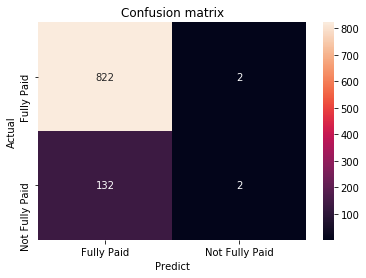

In [149]:
print('  ', 'predict -->')
print ('a    ', 'N', ' P')
print('c ', 'N', 'TN', 'FP')
print('t ', 'P', 'FN', 'TP')
print('^', '', ' ', ' ')
print('|', '', ' ', ' ')
print(' ', '', ' ', ' ')

# Confusion matrix whose i-th row and j-th column entry 
# indicates the number of samples with true label being 
# i-th class and prediced label being j-th class.
conf = confusion_matrix(y_test,predictions)
print(conf,'\n')
print('TN', conf[0][0], ', FP', conf[0][1])
print('FN', conf[1][0], ', TP', conf[1][1])

accu = (conf[0][0]+conf[1][1])/(conf[0][0]+conf[0][1]+conf[1][0]+conf[1][1])
print('\nAccuracy = (TP+TN)/(TP+FP+TN+FN) = {:f}'. format(accu))

acc = accuracy_score(y_test, predictions) 
print("The accuracy is {:f}".format(acc)) 


prec1 = (conf[1][1]/(conf[1][1]+conf[0][1]))
print('\nPrecision = (TP)/(TP+FP) = {:f}'. format(prec1))

prec = precision_score(y_test,predictions) 
print("The precision is {:f}".format(prec)) 


rec1 = (conf[1][1]/(conf[1][1]+conf[1][0]))
print('\nRecall = (TP)/(TP+FN) = {:f}'. format(rec1))

rec = recall_score(y_test, predictions) 
print("The recall is {:f}".format(rec)) 

fscore = (2 * prec1 * rec1) / (prec1 + rec1)
print("\nThe F-Score is {:f}".format(fscore))

f1 = f1_score(y_test, predictions)
print("The F1-Score is {:f}".format(f1)) 

LABELS = ['Fully Paid', 'Not Fully Paid'] 
#plt.figure(figsize =(12, 9)) 
sns.heatmap(conf, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('Actual') 
plt.xlabel('Predict') 
plt.show() 

### ROC Curve
A ROC curve is a diagnostic plot that evaluates a set of probability predictions made by a model on a test dataset. A set of different thresholds are used to interpret the `true positive rate` and the `false positive rate` of the predictions on the `positive` (minority) class which for our case is `Not Fully Paid` class, and the scores are plotted in a line of increasing thresholds to create a curve.

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

-    G-Mean = sqrt(Sensitivity * Specificity)

Best Threshold=0.161667, G-Mean=0.641


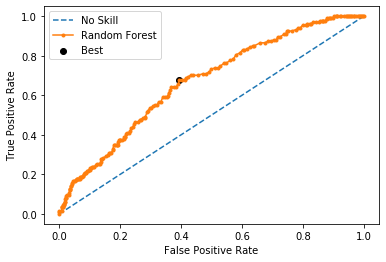

In [158]:
# predict probabilities
yhat = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Precision-Recall Curve

For threshold that results in the best balance of precision and recall, we use F-measure that summarizes the harmonic mean of both measures. F1 scores measures as percent of positive predictions are correct? 

-  F-Measure = (2 * Precision * Recall) / (Precision + Recall)

This threshold could then be used when making probability predictions in the future that must be converted from probabilities to crisp class labels.

Best Threshold=0.161667, F-Score=0.331


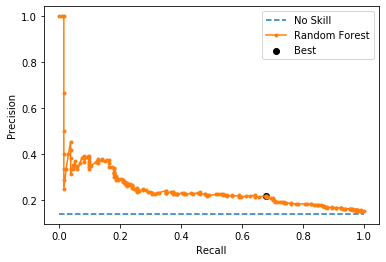

In [148]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
#fscore = f1_score(y_test, predictions)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Optimal Threshold Tuning

Lets define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold. The f1_scores evaluation considers the default threshold of 0.5 when interpreting the probabilities predicted by the model.

Lets test all thresholds between 0.0 and 1.0 with a step size of 0.001, that is, we will test 0.0, 0.001, 0.002, 0.003, and so on to 0.999.

It tuned out that the best threshold is precission = 0.161 with F-Score=0.331. Note, this is also the best threshold for the TPR and FPR from the ROC-curve.

In [157]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# predict probabilities
yhat = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.161, F-Score=0.33091


Lets compare the accuracy, recall, precison and AUC_ROC score for new threshold vs old threshold. The accuracy and precsion has degraded with new threhold, but recall has been drastically improved.

In [170]:
THRESHOLD = 0.161
preds = np.where(rfc.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)


print('Valuation for test data: default threshold')
print(classification_report(y_test, rfc.predict(X_test)))
print("----------------------------------------------------------------------")
print('Valuation for test data: new threshold:')
print(classification_report(y_test, preds))

Valuation for test data: default threshold
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       824
           1       0.67      0.01      0.03       134

    accuracy                           0.86       958
   macro avg       0.76      0.51      0.48       958
weighted avg       0.83      0.86      0.80       958

----------------------------------------------------------------------
Valuation for test data: new threshold:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       824
           1       0.22      0.68      0.33       134

    accuracy                           0.62       958
   macro avg       0.57      0.64      0.53       958
weighted avg       0.82      0.62      0.67       958



## Feature Importance

,feature,importance
1,int.rate,0.115908
6,days.with.cr.line,0.111507
2,installment,0.111467
8,revol.util,0.109396
3,log.annual.inc,0.107070
4,dti,0.106787
7,revol.bal,0.106009
5,fico,0.085102


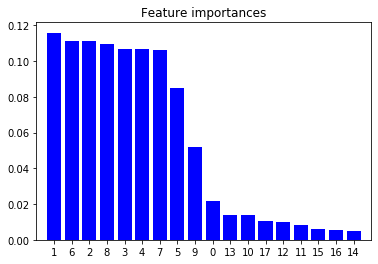

In [177]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([rfc.feature_importances_ for tree in rfc.estimators_],
             axis=0)

# Create a dataframe to map features to their importances
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = importances

# Print out important features
df_fet = features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)
display(df_fet)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## DecisionTreeClassifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
predictions = ??
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       824
           1       0.16      0.22      0.19       134

    accuracy                           0.73       958
   macro avg       0.51      0.52      0.51       958
weighted avg       0.77      0.73      0.75       958



## GradientBoostingClassifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       824
           1       0.38      0.04      0.07       134

    accuracy                           0.86       958
   macro avg       0.62      0.51      0.50       958
weighted avg       0.80      0.86      0.80       958



## CatBoostClassifier

In [1]:
from catboost import CatBoostClassifier
clfas= CatBoostClassifier()
#clfas.fit(X=X_train, y=y_train,eval_set=(X_test,y_test),plot=True)



In [31]:
(clfas.get_feature_importance(prettified=True,verbose=True))

,Feature Id,Importances
0,int.rate,14.405367
1,log.annual.inc,11.193711
2,installment,9.680784
3,revol.bal,8.930214
4,days.with.cr.line,8.588952
5,inq.last.6mths,7.667081
6,fico,7.303687
7,revol.util,7.269430
8,dti,6.027224
9,credit.policy,5.018601


In [32]:
y_pred = clfas.predict(X_test)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[821   3]
 [131   3]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       824
           1       0.50      0.02      0.04       134

    accuracy                           0.86       958
   macro avg       0.68      0.51      0.48       958
weighted avg       0.81      0.86      0.80       958



# Conclusion and ToDo
**Which model is best given data? Looks like Random Forest and DecisionTreeClassifier**


A lot can be done to improve the performance of classifiers discussed here:
    - Data Preparation: Feature Engineering, Under and Over sampling
    - Check out other classifiers such as Boosted Decision Trees
    - Model's paramater tuning: Grid search
    ...so on